#Obtaining a Heat Map of the areas most influential in sorting chest X-ray images.
##The study focuses on the two most similar types (Covid - Pneumonia).

###Introduction:
The neural network is based on the idea of ​​giving each of the factors that are considered an input to the neural network specific weights, and therefore, during the training phase of the neural network, the weights are adjusted through the loss function and the optimization follower used.
In convolutional neural networks, in each of the layers it is stacked using convoluation and pooling layers, and thus the goal is to get a feature map and finally through Perceptron layers the weights are modified for each feature map and thus we will benefit from the weights that were reached at the end Training from the last layer, in addition to making use of the last conv2D layer within the proposed neural network.

###The steps for extracting a heat map for X-ray images are summarized as follows:
- Proposing a convolutional neuron structure to classify two types of X-ray images (Covid, pneumonia).
- Training the proposed neural network and reaching the highest possible accuracy.
- Experimentation on a single image to reach (image rating prediction).
- Obtaining the weights through which the required classification was reached.
- Get the last feature map that precedes the classification layer (I'll explain this step in detail in Notebook).
- Try to expand the feature map to be in the form of (224, 224) and at this stage it can be expanded to the size you want.
- Multiply the feature map matrix after expansion with the matrix of weights obtained from the previous steps. (In this stage, we determine the values ​​of the most important pixels that the neural network will rely on during the classification process) (ie, at this stage we determine the feature map values ​​that have the highest weights).
- In the last stage, we will display the feature map image after expanding and multiplying it by the weights values, as well as showing the base image that has the same dimensions as the first image.

In [1]:
import tensorflow as tf
tf.__version__

'2.6.4'

# Download Dataset and Chexnet Weights

In [4]:
import opendatasets as op
op.download("https://www.kaggle.com/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading covid19-radiography-database.zip to ./covid19-radiography-database


100%|██████████| 778M/778M [00:38<00:00, 21.4MB/s] 


In [5]:
op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading chexnet-weights.zip to ./chexnet-weights


100%|██████████| 25.4M/25.4M [00:02<00:00, 11.6MB/s]


# Import Packages

In [2]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [7]:
dataset_folder = os.path.join("covid19-radiography-database/COVID-19_Radiography_Dataset")

# Delete unimportant files for our study

In [8]:
files_not_important = ["COVID.metadata.xlsx", 
                       "Lung_Opacity.metadata.xlsx",
                       "Normal.metadata.xlsx",
                       "README.md.txt",
                       "Viral Pneumonia.metadata.xlsx"]
for i in files_not_important:
  os.remove(os.path.join(dataset_folder, i))

In [9]:
import shutil
files_not_important = [
                       "COVID/masks",
                       "Lung_Opacity",
                       "Normal",
                       "Viral Pneumonia/masks"]
for i in files_not_important:
  shutil.rmtree(os.path.join(dataset_folder, i), ignore_errors=True)

In [10]:
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))

In [11]:
len(images)

4961

In [12]:
image_data_generator = ImageDataGenerator(
    rescale = 1/255, vertical_flip= False, horizontal_flip=True, zoom_range=0.1, zca_whitening=False,
    samplewise_center=True, samplewise_std_normalization=True, validation_split= 0.1,
    rotation_range=0.2)
training_dataset = image_data_generator.flow_from_directory(
    dataset_folder, target_size = (224, 224), color_mode ='rgb',subset='training', batch_size=8, shuffle=True
)
validation_dataset = image_data_generator.flow_from_directory(
    dataset_folder,  target_size=(224, 224), color_mode = 'rgb', subset='validation', batch_size = 8, shuffle = True
)

Found 4466 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/ai_car/anaconda3/envs/Python3.7/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

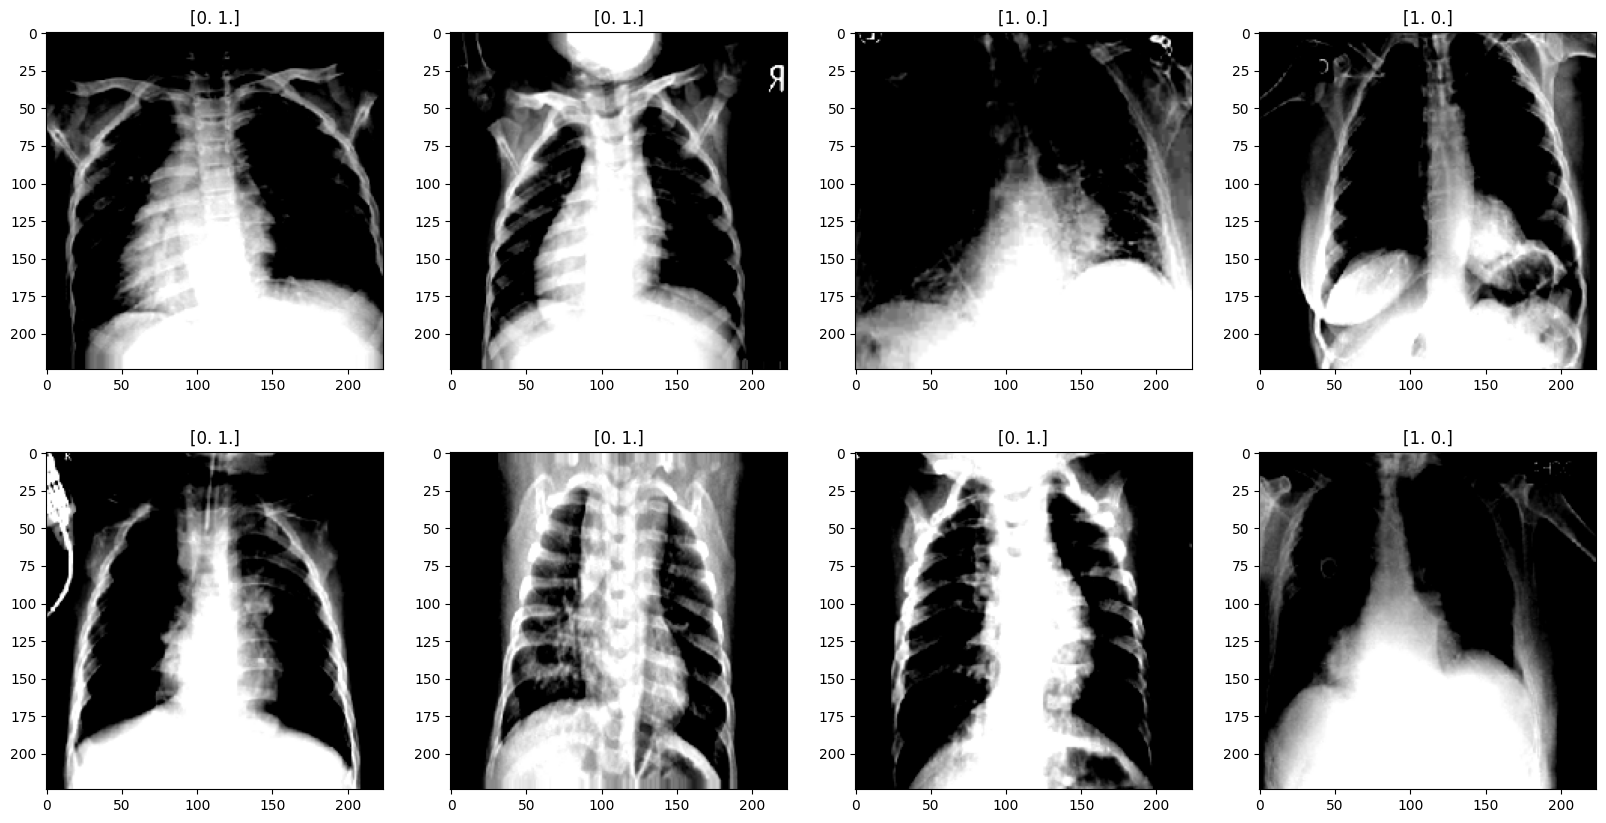

In [13]:
single_batch = training_dataset.next()
images = single_batch[0]
label = single_batch[1]
plt.figure(figsize = (20, 10))
for i in range(8):
  plt.subplot(2, 4, (i + 1))
  plt.imshow(images[i])
  plt.title(label[i])
plt.show()

In [14]:
training_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [15]:
training_dataset.class_indices

{'COVID': 0, 'Viral Pneumonia': 1}

In [16]:
np.asarray(images[0]).shape

(224, 224, 3)

In [17]:
np.unique(images[0])

array([-3.3647392, -3.36463  , -3.3637624, ...,  1.6498648,  1.6499295,
        1.649994 ], dtype=float32)

# Build Our Model
## Suggesting a neural network architecture to classify two types of chest X-ray images.
- At this stage we will explain the methodology that was followed in proposing the appropriate structure.
Here we will explain how the neural network architecture was 
- proposed, where we will show the importance of not using a Flatten layer and using a GlobalAveragePooling2D layer or a GlobalMaxPooling2D layer or combining them together in the ability to generate a heatmap.

In [3]:
from keras.applications import densenet
from keras.initializers import GlorotNormal
d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))

2022-12-29 02:03:54.327127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 02:03:54.453059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ai_car/anaconda3/envs/Python3.7/lib/python3.7/site-packages/cv2/../../lib64:
2022-12-29 02:03:54.453077: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-29 02:03:54.453550: I tensorflow/core/platform/cpu_feat

In [19]:
print(d.output_shape)
m = tf.keras.layers.Dropout(0.7)(d.output)
m = tf.keras.layers.GlobalAveragePooling2D()(m)                         
m = tf.keras.layers.Dropout(0.7)(m)
m = tf.keras.layers.Dense(2, kernel_initializer=GlorotNormal(),
                          activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
for layer in m.layers[:200]:
    layer.trainable = False
for layer in m.layers[200:]:
    layer.trainable = True

(None, 7, 7, 1024)


In [20]:
m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
          , loss = 'categorical_crossentropy', metrics =  [TruePositives(name='tp'),
                                                          FalsePositives(name='fp'),
                                                          TrueNegatives(name='tn'),
                                                          FalseNegatives(name='fn'), 
                                                          'accuracy',
                                                          Precision(name='precision'),
                                                          Recall(name='recall')])

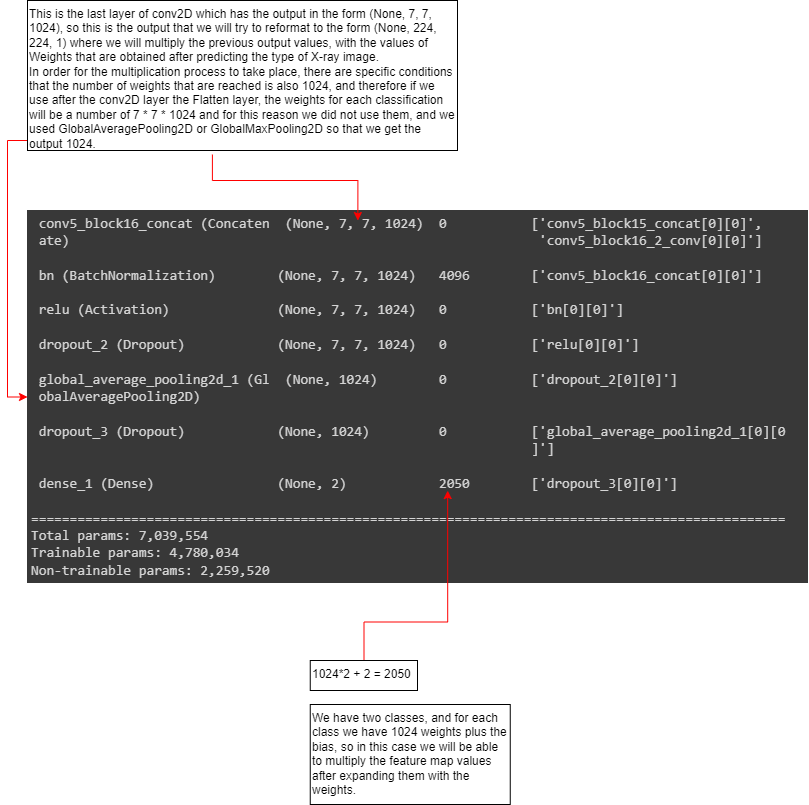

In [ ]:
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [21]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                                  patience= 2)

In [22]:
history = m.fit(
    training_dataset,
    validation_data = validation_dataset,
    batch_size = 8,
    epochs = 50,
    callbacks = [ReduceLROnPlateau,
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode = 'min',
                                                  restore_best_weights=True)]
)

2022-12-22 11:13:43.284632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
559/559 [==============================] - 495s 873ms/step - loss: 0.6464 - tp: 3028.0000 - fp: 1438.0000 - tn: 3028.0000 - fn: 1438.0000 - accuracy: 0.6780 - precision: 0.6780 - recall: 0.6780 - val_loss: 0.3894 - val_tp: 384.0000 - val_fp: 111.0000 - val_tn: 384.0000 - val_fn: 111.0000 - val_accuracy: 0.7758 - val_precision: 0.7758 - val_recall: 0.7758
Epoch 2/50
559/559 [==============================] - 485s 867ms/step - loss: 0.2722 - tp: 3934.0000 - fp: 532.0000 - tn: 3934.0000 - fn: 532.0000 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - val_loss: 0.0539 - val_tp: 492.0000 - val_fp: 3.0000 - val_tn: 492.0000 - val_fn: 3.0000 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 3/50
559/559 [==============================] - 482s 863ms/step - loss: 0.0902 - tp: 4331.0000 - fp: 135.0000 - tn: 4331.0000 - fn: 135.0000 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - val_loss: 0.0211 - val_tp: 492.0000 - val_fp: 3.0000 - val_tn: 49

## Result of Training

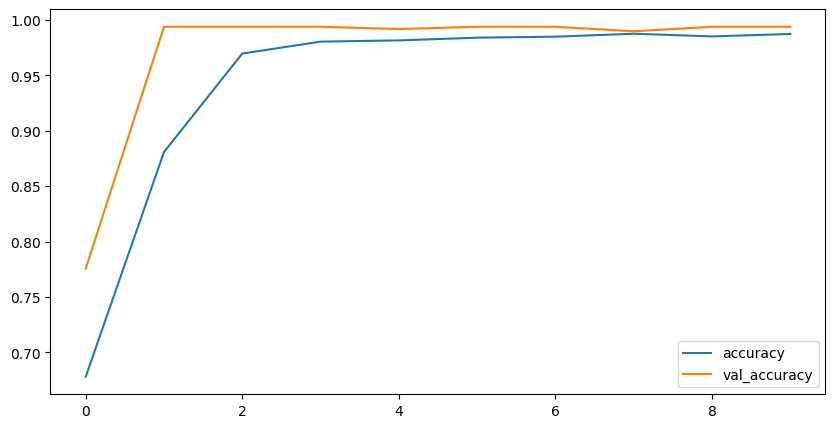

In [23]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()

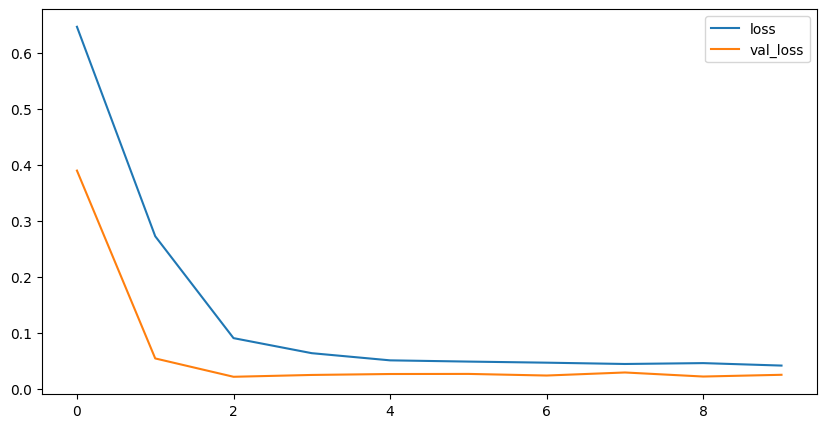

In [24]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

In [25]:
m.evaluate(validation_dataset, batch_size = 8)

62/62 [==============================] - 26s 413ms/step - loss: 0.0310 - tp: 493.0000 - fp: 2.0000 - tn: 493.0000 - fn: 2.0000 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960


[0.031038325279951096,
 493.0,
 2.0,
 493.0,
 2.0,
 0.9959595799446106,
 0.9959595799446106,
 0.9959595799446106]

In [26]:
m.save("/home/ai_car/Preprocessing-MedicalImage/model/brain_tumor.h5")

In [4]:
m = tf.keras.models.load_model("/home/ai_car/Preprocessing-MedicalImage/model/brain_tumor.h5")


#Heat Map Image

In [5]:
single_image = cv2.imread(
    '/home/ai_car/Preprocessing-MedicalImage/image/00003349_000.png'
)
single_image = cv2.resize(single_image, (224, 224))
single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)

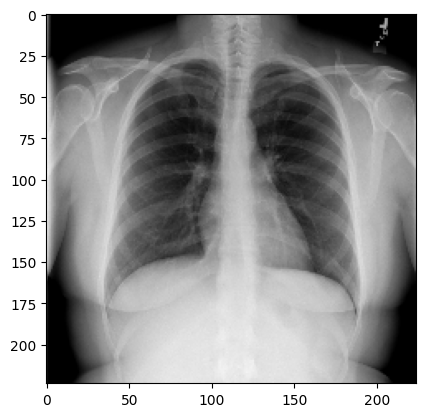

In [6]:
plt.imshow(single_image)
plt.show()

In [7]:
single_image.shape

(224, 224, 3)

In [8]:
img = single_image/255

In [9]:
img = np.asarray(img)
img = img.reshape(1, 224, 224, 3)
img.shape

(1, 224, 224, 3)

In [10]:
y_pred = m.predict(img)[0]

2022-12-29 02:15:09.506875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
y_pred

array([9.9999917e-01, 7.9722156e-07], dtype=float32)

In [12]:
y_pred = np.argmax(y_pred)

In [13]:
y_pred

0

In [14]:
classes = list({'COVID': 0, 'Viral Pneumonia': 1})

In [15]:
classes[y_pred]

'COVID'

In [16]:
# Retrieve the weights from the last layer, without paying attention to the bias values
weights = m.layers[-1].get_weights()[0]

In [17]:
weights

array([[ 0.00145752, -0.10569485],
       [-0.03198315, -0.02157469],
       [ 0.06859788,  0.00457169],
       ...,
       [-0.00516086, -0.02077178],
       [ 0.0547981 , -0.01356133],
       [-0.04854963, -0.03099686]], dtype=float32)

In [18]:
weights = np.asarray(weights)

In [19]:
# we have two class so we have two array in each one we have 1024 weights
weights.shape

(1024, 2)

In [20]:
weights = weights.reshape(weights.shape[1], weights.shape[0])

In [21]:
weights.shape

(2, 1024)

In [22]:
# get weights for the predication class
weights_for_predicted_class_for_this_image = weights[y_pred]

In [23]:
weights_for_predicted_class_for_this_image

array([ 0.00145752, -0.10569485, -0.03198315, ...,  0.00219134,
       -0.02065327,  0.05161493], dtype=float32)

In [24]:
# get out of last convolution layer by name
new_model = tf.keras.models.Model(
    m.input, 
    m.get_layer('conv5_block16_concat').output
)

In [25]:
output_con_layer = new_model.predict(img)[0]

In [26]:
output_con_layer.shape

(7, 7, 1024)

In [27]:
import scipy as sc

In [28]:
# resize image of ouput of last conv2d, using zoom 
resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                  int(224/output_con_layer.shape[1]), 1))

In [29]:
resize_image.shape

(224, 224, 1024)

In [57]:
weights_for_predicted_class_for_this_image.shape

(1024,)

In [58]:
# array_shape(224*224, 0124) * array_shape(1024, 1) = array_shape(224*224, 1)
# final reshape (224*224, 1) to shape (224, 224, 1)
final_image = np.dot(
    resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
    weights_for_predicted_class_for_this_image
).reshape(resize_image.shape[0], resize_image.shape[1])

In [59]:
final_image.shape

(224, 224)

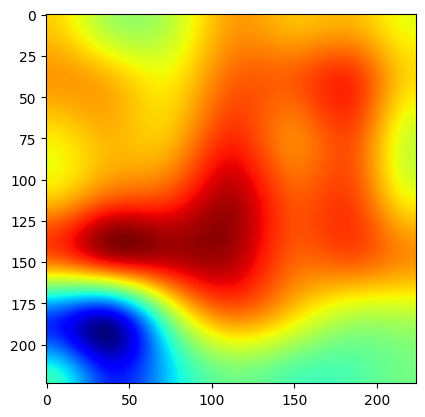

<Figure size 300x300 with 0 Axes>

In [60]:
# heatmap image
plt.imshow(final_image, cmap='jet')
plt.figure(figsize = (3, 3))
plt.show()

In [61]:
img.shape

(1, 224, 224, 3)

In [62]:
img_ = img.reshape(224, 224, 3)
img_.shape

(224, 224, 3)

In [63]:
from matplotlib.patches import Rectangle   

In [64]:
np.unique(final_image)

array([-12.570833 , -12.567671 , -12.566428 , ...,   3.713355 ,
         3.7144463,   3.715489 ], dtype=float32)

In [65]:
final_image.shape

(224, 224)

In [66]:
final_image = final_image/255

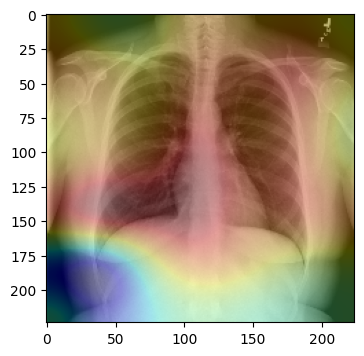

In [67]:
plt.figure(figsize = (4, 4))
plt.imshow(single_image)
plt.imshow(final_image, cmap='jet', alpha=0.3)

# Full function

In [119]:
def getHeatMap(image):
  single_image = cv2.imread(image)
  single_image = cv2.resize(single_image, (224, 224))
  single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
  img = single_image/255
  img = np.asarray(img)
  img = img.reshape(1, 224, 224, 3)
  y_pred = m.predict(img)[0]
  y_pred = np.argmax(y_pred)
  classes = list({'COVID': 0, 'Viral Pneumonia': 1})
  class_prediction = classes[y_pred]
  weights = m.layers[-1].get_weights()[0]
  weights = np.asarray(weights)
  weights = weights.reshape(weights.shape[1], weights.shape[0])
  weights_for_predicted_class_for_this_image = weights[y_pred]
  new_model = tf.keras.models.Model(
    m.input, 
    m.get_layer('conv5_block16_concat').output
    )
  output_con_layer = new_model.predict(img)[0]
  resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                  int(224/output_con_layer.shape[1]), 1))
  final_image = np.dot(
      resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
      weights_for_predicted_class_for_this_image
  ).reshape(resize_image.shape[0], resize_image.shape[1])
  img_ = img.reshape(224, 224, 3)
  final_image = final_image/255
  return [img_, final_image, class_prediction]

In [115]:
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))
arr = []
for i in images[:8]:
  arr.append(getHeatMap(os.path.join(i)))

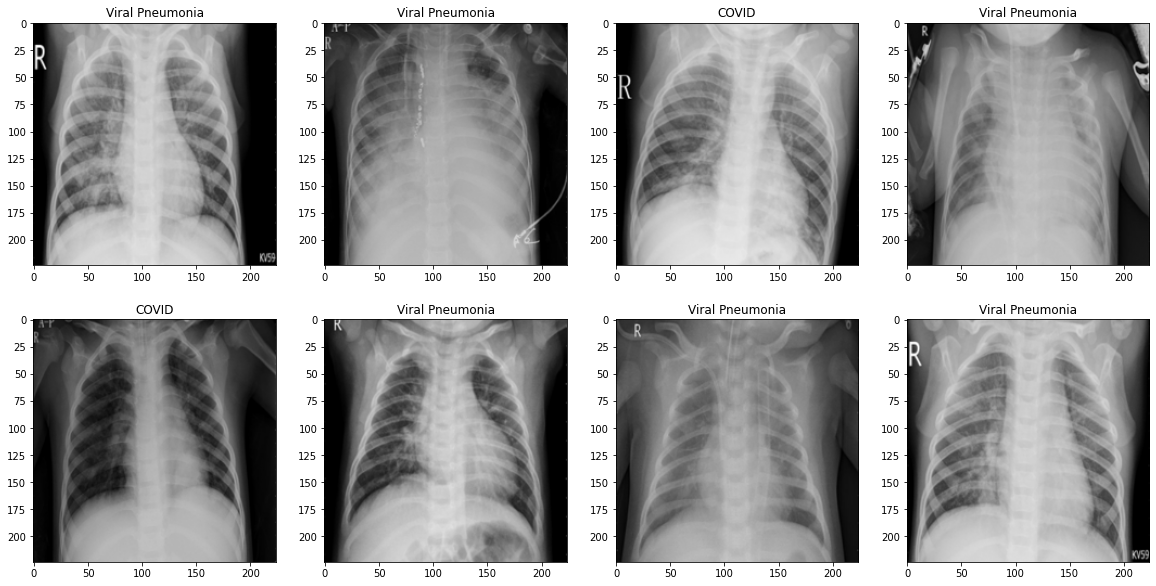

In [116]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.title(i[2])
plt.show()  

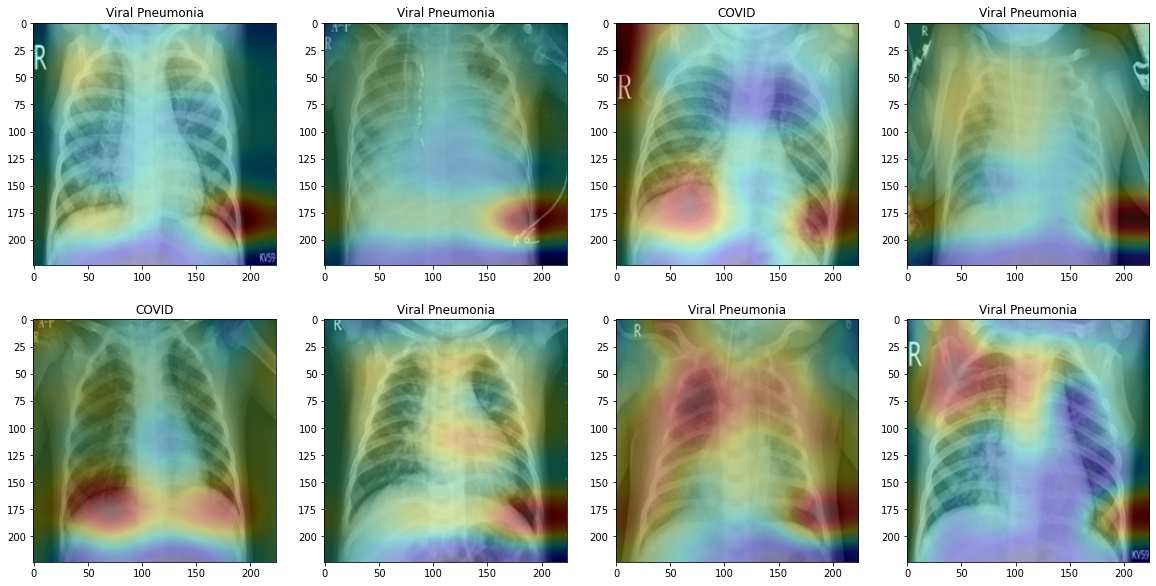

In [117]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.imshow(i[1], cmap='jet', alpha=0.3)
  plt.title(i[2])
plt.show()  